# Facial Recognition (Part II: Eigenfaces)

In the last lab, we looked at using SVD to determine a region of the $x-y$ plane in which pairs of measurements describing faces fell. While that is not sufficient for personal identification, such measurements can provide a basis. In fact, a set of fourteen measurements formed an alternative to fingerprinting for a very long time ([Muller, Magaia, and Herbst, 2004](https://epubs.siam.org/doi/pdf/10.1137/S0036144501387517)).

Today, we will take a different approach. Modern facial identification works from digital images rather than from detailed measurements. Ideally, a computer should be able to label a new image as a face, and to then identify it by name. This is an example of *machine learning*. Today, we will use a set of facial images to train a classifier, then test it. We will use two different facial databases:

* The Olivetti Research Laboratory database, that is described in [Samaria and Harter, 1994](https://ieeexplore.ieee.org/document/341300/), a database of 400 images taken at different times, varying lighting slightly, facial expressions (open/closed eyes, smiling/non-smiling) and facial details (glasses/no-glasses).  All the images were taken against a dark homogeneous background and the subjects are in up-right, frontal position (with tolerance for some side movement). Each images is 8 bit grayscale, of size $92\times 112$ pixels.<br><br>
* A subset of The Extended Yale Face Database B, described in [Georghiades and Belhumeur, 2001](http://webdocs.cs.ualberta.ca/~jag/papers/belhumeur/pami_ipSubmRevA02.pdf). This is a very large database of faces taken under variable lighting directions. Of the 16,128 images, we will use a subset of around 2,400 images. We will restrict ourselves to the photos taken from the front, though we will consider many lighting conditions. Again, these are 8 bit grayscale images, this time of size $192\times168$ pixels.

We will not measure the width between ears, or any other features of the faces. Instead, we will look at the images themselves as *representations* of the faces: If we have an $m\times n$ 8 bit grayscale image, we can see it as an $m\times n$ matrix with entries from $0$ to $255$. We will reshape the images into a single vector in $\mathbb{R}^{mn}$ (note: $mn$ is *very* large -- around $10,000$ for the first set of images, and over $30,000$ for the second.)

Just as we saw in the last lab, we will find that these vectors occupy what is essentially a small part of these very high-dimensional spaces. We will further find that the *effective dimension* of these regions is much lower. By computing an orthogonal basis of eigenvectors (called *eigenfaces* in this context) and projecting our vectors onto them, we will find a relatively compact encoding of each image.

Once we have the coordinates in the projected space, we will find that images of the same person cluster together. By finding the closest vector whose label is known to a given image whose label is unknown, we will attempt to label unknown images.

> ## Make a copy of this notebook (File menu -> Make a Copy...)

## The Olivetti Research Lab Database

The images for the ORL database are in the *data/ORLdatabase* folder. They are sorted by subject (in folders numbered s1 to s40). This will allow us to label the images. As stated above, the images are 8 bit grayscale and $112\times 92$.

I wrote a function `readORLDatabase(path)` to read the files. Use it as follows:
```python
from imagefunctions import readORLDatabase
faces,labels,ht,wd,numimages = readORLDatabase('data/ORLfacedatabase/')
```

After you run this, *faces* will be a 3-D NumPy array with *numimages* 'rows', each of which is a *ht* $\times$ *wd* array. *labels* will be a 1 dimensional NumPy array of integers with *numimages* entries, corresponding to the folder numbers. *ht* and *wd* will be $112$ and $92$ respectively.

**Question 1** Let's look at the images of the first ten subjects. These are the first hundred images in the *faces* array. To display a bunch of images together, use a command I wrote (from *imagefunctions.py* again):
```python
%matplotlib notebook
from imagefunctions import showblockgray
showblockgray(faces[:100])
```

Comment on the differences between the images for each subject.

> **Important practical note: We use the *notebook* backend to Matplotlib for various reasons in this lab. This has one big disadvantage -- you need to make each image non-interactive before moving on by clicking the blue off symbol in the top-right of the figure. Otherwise later figures won't work!** 

<IPython.core.display.Javascript object>


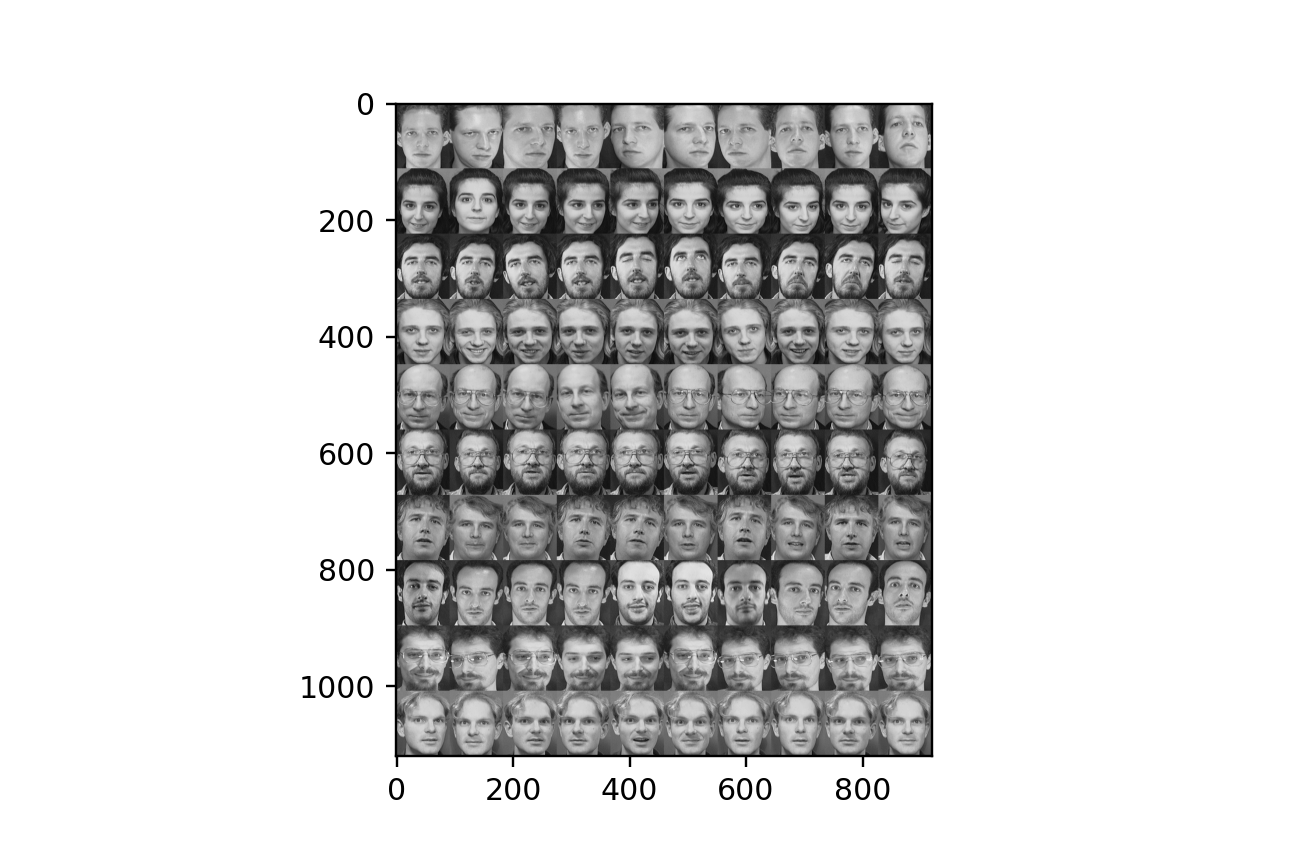

In [26]:
from imagefunctions import readORLDatabase
faces, labels, ht, wd, numimages = readORLDatabase('data/ORLfacedatabase/')
%matplotlib notebook
from imagefunctions import showblockgray
showblockgray(faces[:100])

In order to do computation, we will need to *reshape* the 3-D array into a 2-D array, each column of which is a flattened $112\times 92$ vector. To do this:
```python
facearray = (faces.reshape(numimages,ht*wd)).T
```
Next, we will split the set of faces into a *training set* and a *testing set*. We will use the training set to compute eigenfaces and carry out the principal component analysis.

**Question 2** Create new arrays named *trainset* and *trainlabels* that consists of a random sample of half the columns of *facearray* and their labels respectively (that is, 200 images and labels out of the 400 total). As oyu may have seen on the very first homework, you can get a random sample of 200 of the integers between 0 and 399 by taking a random permuation of the first 400 integers and look at the first 200 of them:
```python
randomized = np.random.permutation(400)
trainnum = randomized[:200]
```

In [27]:
import numpy as np
facearray = (faces.reshape(numimages,ht*wd)).T
np.random.seed(20)
randomized = np.random.permutation(400)
#print(randomized)
trainnum = randomized[:200]
trainset = facearray[:,trainnum]
#print(trainset)
trainlabels = labels[trainnum]
#print(labels)
#print(trainlabels)

**Question 3** In the last lab, we subtracted the average measurement before carrying out SVD.

* Find the average face (using `np.average(facearray,axis=1)`), then display it:

```python
%matplotlib inline
import matplotlib.pyplot as plt

plt.gray()
plt.imshow(avgface.reshape(ht,wd)) # Since the face is a column, we need to reshape to display it!
```
* Next, subtract the average from each of the images in your training set: `normfaces = (facearray.T - avgface).T` (again, see the first lab for why this works).
* Then compute the SVD of your normalized faces array, storing the results in the variables *u*, *s*, and *vt*.

(As before, remember to you use the *full_matrices = False* option of the svd command. This will keep the matrices to a manageable size.)

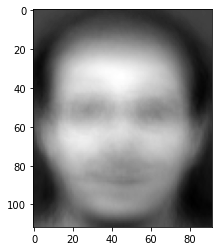

In [54]:
avgface = np.average(trainset,axis=1)
%matplotlib inline
import matplotlib.pyplot as plt
plt.gray()
plt.imshow(avgface.reshape(ht,wd))
normfaces = (trainset.T - avgface).T
u,s,vt = np.linalg.svd(normfaces, full_matrices = "false") 

**Question 4** The columns of *u* form an orthogonal basis of a subspace of $\mathbb{R}^{112\times 92}$. What is the dimension of this subspace?

Now for the fun part. Just as each of the principal directions in the last lab were vectors in $\mathbb{R}^2$, the principal directions (given by the columns of *u*) are vectors in $\mathbb{R}^{112\times 92}$. Therefore, we can see the principal direction as images themselves! These principal directions are called *eigenfaces*.

**Question 5** Using *showblockgray*, display the first 25 eigenfaces:
```python
efaces = (u[:,:25].T).reshape(25,ht,wd) # Think about why this is the right way to do this!
showblockgray(efaces)
```
Comment on the images. Specifically, note the differences between the first few and the rest.

(10304, 10304)


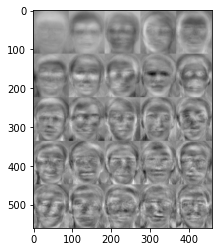

In [55]:
print(np.shape(u))
#print(112*92)
efaces = (u[:,:25].T).reshape(25,ht,wd) # Think about why this is the right way to do this!
showblockgray(efaces)

Note that the first few eigenfaces contain general facelike information, whereas the rest pick out some specific features. 

We will use these eigenfaces for two purposes: first, we will attempt to reconstruct images using only the first few of the 200 eigenfaces. Just as we did in Lab 12, we will hopefully find that we get recognizable faces with far fewer than 200 principal directions. Then, we will find the coodinates along the first few principal directions of our training images and our test images. By finding the distance of an unknown image from all the known images, we will try to figure out which subject it represents.

### Low Dimensional Facial Reconstruction

In the last lab, we computed the coordinates along the first principal axis of the data points. On the homework, we saw that we can achieve the same thing by computing $u_1^TX$, where $u_1$ is the first column of $u$ and $X$ the normalized data. Likewise, we can find the coordinates along the first $n$ principal directions by computing $u_n^TX$, where $u_n$ is the first $n$ columns of $U$. That is, if $f_1$ is the first normalized face (the first column of $X$), $e_i$ is the $i^{th}$ eigenface, and $u_n^Tf_1 = \begin{bmatrix} c_1 & c_2 & \ldots c_n\end{bmatrix}^T$, then $$f_1 \approx c_1 e_1 + c_2 e_2 + \ldots c_n e_n = u_nu_n^T f_1.$$

We can then get the actual face back by adding the average face.

Note that we can see from this that $u_nu_n^T$ is the projection matrix onto the first $n$ eigenfaces.

Make sure you understand this! Referring back to the previous lab, we have exactly one coordinate (as we computed $u_1^TX$). Then if $f_i$ is the $i^{th}$ measurement, then $u_1u_1^Tf_i = c_ie_1$, with $c_i$ is the distance from the center of the ellipse to the projection of the $i^{th}$ measurement onto the first principal axis (whose eigenvector is $e_1$).

**Question 6** Using the first column of your random sample array, compute the reconstruction above for increasing values of $n$:
```python
from ipywidgets import interact
import ipywidgets as widgets

fig, ax = plt.subplots()

@interact(numefaces=widgets.IntSlider(min=1,max=400,step=1,value=1,continuous_update=False))
def update(numefaces):
    ax.imshow((u[:,:numefaces]@u[:,:numefaces].T@normfaces[:,0] + avgface).reshape(ht,wd),cmap='gray')
```

At what point do you recognize which subject is depicted? 

<IPython.core.display.Javascript object>


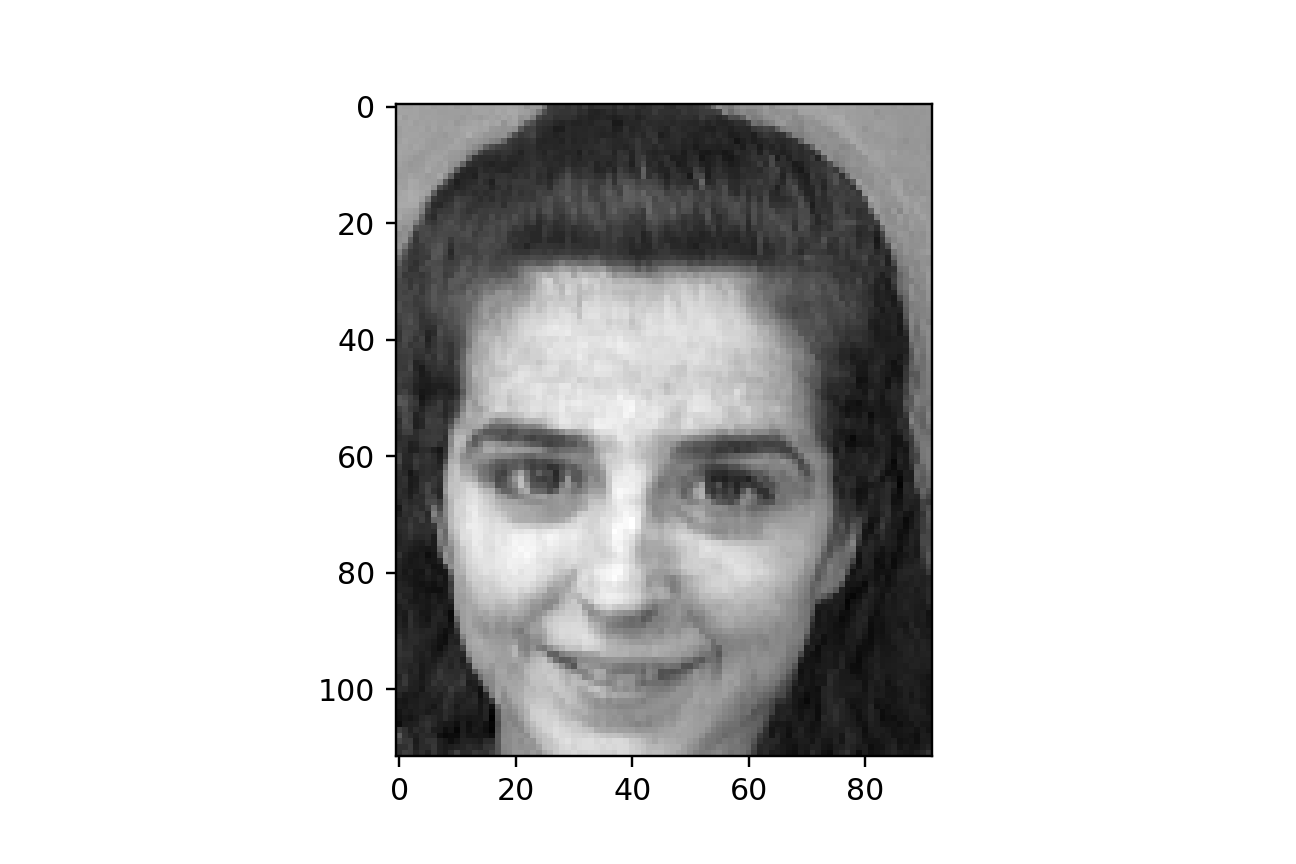

interactive(children=(IntSlider(value=1, continuous_update=False, description='numefaces', max=200, min=1), Ou…

In [45]:
from ipywidgets import interact
import ipywidgets as widgets

%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

@interact(numefaces=widgets.IntSlider(min=1,max=200,step=1,value=1,continuous_update=False))
def update(numefaces):
    ax.imshow((u[:,:numefaces]@u[:,:numefaces].T@normfaces[:,0] + avgface).reshape(ht,wd),cmap='gray')
    #un@unT
    



### Automated Face Recognition

We now aim to figure out which subject is represented by a given picture. Our strategy will be as follows:
* Create a test set of all images not in our training set. Then subtract the average *of the training set*.<br><br>
* Find the true labels for each of these (we will pretend we don't know these, then test our results against the correct answers).<br><br>
* Find the coordinates of each image along the first $n$ eigenfaces (principal directions) we found before by multiplying by $u_n^T$. Same for the training images.<br><br>
* Find the distances between the coordinates of a given test image and the coordinates of each of the images in the training set.<br><br>
* Predict a label for an unknown image (from the test set) to be the label of the training set image closest to it.

This will give us a set of predicted labels for each image in the test set. We can then find the total number of differences between the correct labels and our predicted ones to find our rate of success.

**Question 7** Implement the above procedure. What are your rates of success for $n$ between, say, 1 and 50? Does there appear to be a ceiling on the possible success rate? How does this compare to your manual recognition from Question 6 above?

> **Notes on implementation:** 
> * You can get the distance between two vectors *u* and *v* by using `np.linalg.norm(u,v)`. 
> * Once you have all the distances in an array *D*, you can use the aggregating function `np.argmin(D,axis=n)` (where you need to figure out what *n* should -- see the first lab) to find the image in the training set closest to each image in the test set.
> * Once you have those, you can use logical indexing to get the labels the model predicts for your images.
> * Of course, there are many ways to do this. The above are just suggestions.

In [48]:
#make test set, subtract avg of training set, multiply bu ut to project into space, find what set of coordinates it is 
#closest to ->find label based off of the labels in the training set; uT * training set matrix
testnum = randomized[200:]
testset = facearray[:,testnum]
testlabels = labels[testnum] #true labels, pretend we do not know this information

In [131]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#plt.gray()
#plt.imshow(avgface.reshape(ht,wd))
testnormfaces = (testset.T - avgface).T
newefaces = (u[:,:25].T).reshape(25,ht,wd) # Think about why this is the right way to do this!
#showblockgray(newefaces)
n = 40;
def faces (numefaces):
    testimg = ((u[:,:numefaces]).T@testnormfaces)
    trainedimg = ((u[:,:numefaces]).T@normfaces)
    return (testimg,trainedimg)
testimg,trainedimg = faces(n)
D = np.zeros((n,n))
for i in range (0,n):
    for j in range(0,n):
        D[j,i] = np.linalg.norm(testimg[:,i]-trainedimg[:,j])
print(D)  
minfaces = (np.argmin(D,axis=0))
#print(D[:,119])
#print(D)
print(minfaces)
predicted = trainlabels[minfaces]
#print(testlabels)
#print(testlabels[minfaces])
#print(trainlabels)
print(np.sum(predicted == testlabels[:n])/n) #see how many were correctly predicted

[[5791.60476338 4609.25148907 5263.14465711 ... 7252.37581136
  6163.39305537 5977.4464358 ]
 [4419.98190275 5246.75874937 4507.17687116 ... 5350.02805188
  4964.68464243 5064.77425082]
 [4134.68707195 3940.06723563 4558.82678063 ... 5834.03086388
  4593.36084769 4163.43728569]
 ...
 [4557.60162948 4919.56733219 4471.83478721 ... 4095.0290617
  1910.51172874 4085.55821197]
 [5091.27205239 3458.42997147 3836.38993495 ... 5948.7029718
  5099.87669846 5168.78164994]
 [4173.98038984 3704.72906295 3951.8541292  ... 5800.80848671
  5295.35149663 4965.99279492]]
[ 7 19 26 38  2  0  2 18  3 39 19 23  7  8 12 22 12 19 22  9  5  2  3 23
 19 36 28 19 13 12  8 22 25 29 34 29 12 14 37 16]
0.575


### The Extended Yale Face Database B

The Yale database is stored in the folder *data/yalefaces/CroppedYale/*. Use the `readYaleDatabase(foldername)` command from *imagefunctions.py* to read the images. The syntax is the same as the command to read the ORL database. The main difference from the ORL database is that here, we are looking at subjects lit from a variety of angles, from far to their left, through straight ahead, through far to their right. Unlike with the ORL database, subjects are making the same facial expressions. Lighting is the main difference between images of a given subject.

**Question 8** Run a similar analysis to the one above. Note that the images here are much larger, and there are many more of them. As before, remember to you use the `full_matrices = False` option of the svd command. This will keep the matrices to a manageable size. While this was essentially optional above, running the full SVD here will crash most computers!

#### Well, that's no good!

As you probably noticed, we get pretty bad results. To explain this, recall that the principal directions in SVD pick out the direction of greatest variation in the set of input vectors. 

**Question 9** What is the biggest variation between images in this database? How might you overcome this? Spend the rest of this lab improving the recognition in the Yale database.